In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

print("All libraries loaded")

All libraries loaded


In [15]:
# Load only a portion of the data to prevent memory issues
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display basic info
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

train_df.head()

Train Shape: (316970, 28)
Test Shape: (79060, 27)


,Unnamed: 0,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,0,6400.0,36 months,15.61,223.78,C,C3,Accountant,< 1 year,RENT,...,12.0,0.0,31228.0,97.6,22.0,f,INDIVIDUAL,0.0,0.0,"354 Palmer Cove\r\nWest Alexa, SD 48052"
1,1,25000.0,60 months,19.99,662.21,E,E1,Electronic Technician,10+ years,MORTGAGE,...,18.0,1.0,24755.0,42.1,64.0,f,INDIVIDUAL,7.0,1.0,"8778 Lopez Street\r\nNew Jacqueline, TN 05113"
2,2,15000.0,36 months,5.32,451.73,A,A1,Transportation Coordinator,10+ years,MORTGAGE,...,12.0,0.0,8925.0,23.3,23.0,w,INDIVIDUAL,4.0,0.0,"21752 William Forest\r\nJeremyberg, WA 05113"
3,3,16000.0,36 months,15.61,559.44,C,C3,ironworker,< 1 year,RENT,...,8.0,0.0,6972.0,79.2,17.0,f,INDIVIDUAL,0.0,0.0,"2707 Brittany Prairie Apt. 007\r\nThomasville,..."
4,4,8725.0,36 months,12.12,290.30,B,B3,Hathaway-Sycamores child & Family Serv,10+ years,MORTGAGE,...,10.0,0.0,25397.0,45.8,32.0,f,INDIVIDUAL,7.0,0.0,"PSC 1131, Box 5667\r\nAPO AA 00813"


In [16]:
# Check for missing values
print("Missing values in train dataset:")
print(train_df.isnull().sum().sort_values(ascending=False))

# Check column data types
print("\nColumn types:")
print(train_df.dtypes)


Missing values in train dataset:
mort_acc                30217
emp_title               18398
emp_length              14676
title                    1397
pub_rec_bankruptcies      430
revol_util                213
grade                       0
installment                 0
int_rate                    0
term                        0
Unnamed: 0                  0
loan_amnt                   0
verification_status         0
annual_inc                  0
home_ownership              0
sub_grade                   0
dti                         0
issue_d                     0
loan_status                 0
purpose                     0
pub_rec                     0
open_acc                    0
earliest_cr_line            0
revol_bal                   0
initial_list_status         0
total_acc                   0
application_type            0
address                     0
dtype: int64

Column types:
Unnamed: 0                int64
loan_amnt               float64
term                     object
int

In [17]:
# Drop columns that are not useful or have too many missing values
columns_to_drop = ['emp_title', 'title', 'address']  # Adjust as needed

train_df = train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], errors='ignore')
test_df = test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], errors='ignore')

train_df.rename(columns=lambda x: x.strip(), inplace=True)  # Removes extra spaces


print("Columns dropped successfully.")


Columns dropped successfully.


In [18]:
# Fill missing values in numerical columns with median
numerical_columns = train_df.select_dtypes(include=['number']).columns.tolist()

# Ensure we don't modify 'loan_status' (target variable) in train_df
if 'loan_status' in numerical_columns:
    numerical_columns.remove('loan_status')

train_df[numerical_columns] = train_df[numerical_columns].fillna(train_df[numerical_columns].median())

# Only fill numerical columns that exist in test_df
numerical_columns_test = [col for col in numerical_columns if col in test_df.columns]
test_df[numerical_columns_test] = test_df[numerical_columns_test].fillna(test_df[numerical_columns_test].median())

# Fill missing values in categorical columns with mode
categorical_columns = train_df.select_dtypes(include=['object']).columns.tolist()

for col in categorical_columns:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

    # Only fill categorical columns that exist in test_df
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

print("Missing values filled.")


Missing values filled.


In [19]:
# Ensure 'term' column is treated as a string before extracting numbers
train_df['term'] = train_df['term'].astype(str).str.extract('(\d+)').astype(float)
test_df['term'] = test_df['term'].astype(str).str.extract('(\d+)').astype(float)

print("Successfully converted 'term' column.")


Successfully converted 'term' column.


In [20]:
# Select numerical columns
numerical_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal']

# Apply Standard Scaling
scaler = StandardScaler()
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

print("Numerical features scaled.")


Numerical features scaled.


In [21]:
# Verify if 'loan_status' exists in train_df before splitting
if 'loan_status' not in train_df.columns:
    print("Error: 'loan_status' column not found in train_df. Check data processing steps.")
else:
    # Define features and target
    X = train_df.drop(columns=['loan_status'])
    y = train_df['loan_status']

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Data split into training and validation sets.")


# Reload 'loan_status' from the original dataset
original_train_df = pd.read_csv('train.csv', nrows=100000)

# Ensure it’s only added if missing
if 'loan_status' not in train_df.columns:
    train_df['loan_status'] = original_train_df['loan_status']
    print("Recovered 'loan_status' column.")

print(train_df.columns)

Data split into training and validation sets.
Index(['Unnamed: 0', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')


In [22]:
if 'loan_status' in train_df.columns:
    X = train_df.drop(columns=['loan_status'])
    y = train_df['loan_status']

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Data split into training and validation sets.")
else:
    print("Error: 'loan_status' is still missing. Check earlier processing steps.")


Data split into training and validation sets.


In [23]:
# Check for non-numeric columns in X_train
non_numeric_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print("Non-numeric columns in X_train:", non_numeric_cols)

# Identify categorical columns (excluding the target variable)
cat_columns = train_df.select_dtypes(include=['object']).columns.tolist()

# Apply One-Hot Encoding to all categorical columns
train_df = pd.get_dummies(train_df, columns=cat_columns, drop_first=True)
test_df = pd.get_dummies(test_df, columns=[col for col in cat_columns if col in test_df.columns], drop_first=True)

# Ensure train and test datasets have the same columns
missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Add missing columns in test set

# Ensure test_df matches train_df's column order (excluding 'loan_status')
test_df = test_df[train_df.columns.drop('loan_status', errors='ignore')]

print("Categorical features encoded successfully.")

print(X_train.select_dtypes(include=['object']).columns.tolist())  # Should return []

for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category').cat.codes
    X_val[col] = X_val[col].astype('category').cat.codes

if 'X_train' in locals():
    random_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
    random_model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = random_model.predict(X_val)

    print("Model training complete.")
else:
    print("Error: X_train is still missing. Check previous steps.")


Non-numeric columns in X_train: ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'earliest_cr_line', 'initial_list_status', 'application_type']
Categorical features encoded successfully.
['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'earliest_cr_line', 'initial_list_status', 'application_type']
Model training complete.


Model Accuracy: 0.8043
Classification Report:
               precision    recall  f1-score   support

 Charged Off       0.60      0.04      0.07     12558
  Fully Paid       0.81      0.99      0.89     50836

    accuracy                           0.80     63394
   macro avg       0.70      0.52      0.48     63394
weighted avg       0.77      0.80      0.73     63394



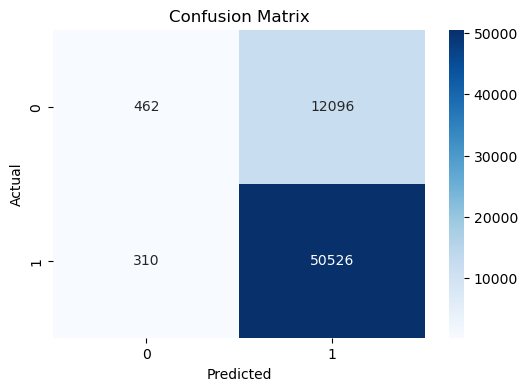

ROC-AUC Score: 0.7093


In [24]:
# Accuracy Score
accuracy = accuracy_score(y_val, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:\n", classification_report(y_val, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_val, random_model.predict_proba(X_val)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")
